In [1]:
# Boring preliminaries
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import numpy as np
import re

# Anomaly detection in CI logs

In this notebook, we detect anomaly in failed job which are in fact novelty of a previous success job.
The key objective is to reduce the time it takes to understand a failure by compressing the information of a failed job output to the relevant bits.

## Theory

First, let's see a trivial example, X_success is a successful job output and X_failure is a failed job output.

In [2]:
X_success = """Starting console log
Setup test environment
Run test 1: ok
Run test 2: ok
Copy logs
Return SUCCESS""".split("\n")

X_failure = """Starting console log
Setup test environment
Run test 1: ok
Run test 2: fail
Traceback (most recent call last):
AttributeError: blah
Run test 3: ok
Copy logs
Return FAILURE""".split("\n")

We can just look for lines that are not present in the success logs

In [3]:
novelty = [line for line in X_failure if line not in X_success]
print("\n".join(novelty))

Run test 2: fail
Traceback (most recent call last):
AttributeError: blah
Run test 3: ok
Return FAILURE


The rest of this notebook will improve this technique to:
* Detect small variations
* Scale for large output

In particular, we want the Traceback to be highlighted and the "Run" statement to be ignored.

### HashingVectorizer

Instead of working with list of words, we are going to use Feature Vectors.
Each line can be converted to a numeric array of token occurence.

The Hashing vectorizer creates a 2^20 sparse array of possible token hash:

In [4]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer()
V_success = vectorizer.transform(X_success)
V_failure = vectorizer.transform(X_failure)

print("Vectors shape:", V_success.shape)
print("Example vector:", repr(V_success[0]))
print("'%s' cells are %s" % (X_success[0], V_success[0].indices))

Vectors shape: (6, 1048576)
Example vector: <1x1048576 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>
'Starting console log' cells are [327488 377854 423052]


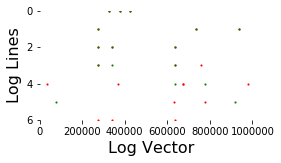

In [5]:
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt

def plot_features_vectors(V_success, V_failure, figsize=(4, 2)):
    def plot_sparse_matrix(ax, sm, color):
        cm = coo_matrix(sm)
        ax.plot(cm.col, cm.row, 's', color=color, ms=1)
        ax.set_xlim(0, cm.shape[1])
        ax.set_ylim(0, cm.shape[0])
        for spine in ax.spines.values():
            spine.set_visible(False)
        ax.set_xlabel('Log Vector', fontsize=16)
        ax.set_ylabel('Log Lines', fontsize=16)
        ax.invert_yaxis()

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    plot_sparse_matrix(ax, V_failure, color='red')
    plot_sparse_matrix(ax, V_success, color='green')

    plt.show()
plot_features_vectors(V_success, V_failure)

The above graph the success/failure vectors in green/red. As you can see, the 4th line shows the first difference when there is "fail" instead of "ok".
The next section introduces a model to compute the distance of each failure vector to the closest success vector.

### NearestNeighbor

Instead of manually comparing each failure vectors with the success vectors, we are going to use an unsupervised learner for implementing neighbor searches.

In [6]:
from sklearn.neighbors import NearestNeighbors
nn = NearestNeighbors()
# Training
nn.fit(V_success)
# Distance calculation
distances, neighbors = nn.kneighbors(V_failure)

The first step is to fit the model using the success vectors as training data.
Then we can query the distances of the failure vectors. The kneighbors method return a list of distances and the corresponding neighbors.

In [7]:
for idx in range(len(distances)):
    print("%.2f | %s" % (distances[idx][0], X_failure[idx]))

0.00 | Starting console log
0.00 | Setup test environment
0.00 | Run test 1: ok
0.82 | Run test 2: fail
1.41 | Traceback (most recent call last):
1.41 | AttributeError: blah
0.00 | Run test 3: ok
0.00 | Copy logs
1.00 | Return FAILURE


The above output show the distances of each failure vectors:

* The Tracback gets the highest score because the tokens are not present in the training data.
* The "Run test" statement gets a lower score because they are similar to the training data.

### Recap

Let's apply the above technique to a real console log, in this example a devstack job:

In [9]:
def load_datasets(name):
    return open("%s/success.log" % name).readlines(), open("%s/failure.log" % name).readlines()

X_success, X_failure = load_datasets("devstack")
# Transform the raw logs to feature vectors
vectorizer = HashingVectorizer()
V_success = vectorizer.transform(X_success)
V_failure = vectorizer.transform(X_failure)
# Train the model
nn = NearestNeighbors()
nn.fit(V_success)
# Compute the distance
distances = nn.kneighbors(V_failure)[0]

In [10]:
min_distance = 0.3
for idx in range(len(X_failure)):
    # Only show lines when the distance increased
    if distances[idx][0] >= min_distance:
        min_distance = distances[idx][0]
        print("%.2f | %s" % (distances[idx][0], X_failure[idx][:-1]))

1.00 | 2018-02-22 00:14:39.906972 | Job console starting...
1.08 | 2018-02-22 00:15:11.357335 | controller -> localhost | SHA256:j8R7j6w+IZ0V6XEw761Uo+G7f+ss9V8zmnq8mZjNBAU zuul@ze08
1.10 | 2018-02-22 00:16:14.585375 | controller -> localhost |  * [new tag]         2010.1 -> 2010.1
1.10 | 2018-02-22 00:16:14.585483 | controller -> localhost |  * [new tag]         2011.1 -> 2011.1
1.16 | 2018-02-22 00:17:24.742290 | controller |   "key": "2001:41d0:302:1000::10:307c ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAABAQCnu5VGRUCsYRfhiMnwJWIDzUP77swRD5X/ENcQX8L9JE9vpjlex5ABAacflupBMMeWvC3C0JZDmdK941bgvw9JtAxlc4goP+hELUAaawXLAKMuV0g3jNC5Zoj6pP+vI8ie48i7zCCh8a/gWYOQDuME2AMQ1DpG6VLm2vVSsgkVnybtHfatOvAvyu62WZlCWJTR1Dilfk/mlFpPvRd0uFLsOE26A3xIkOpAluuHfsPFMAVvTzwbYBj/eyIDtPn2hESUyF4UNjxsu+/Y2OC+w0zS0w/ypqZvfu6qU1Bod8pc4R42wPzgZ2pt+9HfrxLiiAovSEddjGO4ybMFHZnpTV+B",
1.18 | 2018-02-22 00:17:26.306961 | controller |   "key": "fe80::f816:3eff:fe5c:4a23 ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAABAQCnu5VGRUCsYRfhiMnwJWIDzU

This assigned the highest score to what seems to be the issue with this job: the subnode host was unreachable.
However it also assigned *1.00* to the "console starting" line because the training have timestamps.
In theory, with enough training data, small variations like timestamps or new tag can be removed, in practice, we can reduce the noise a lot by cleaning the log line before the vectorization.

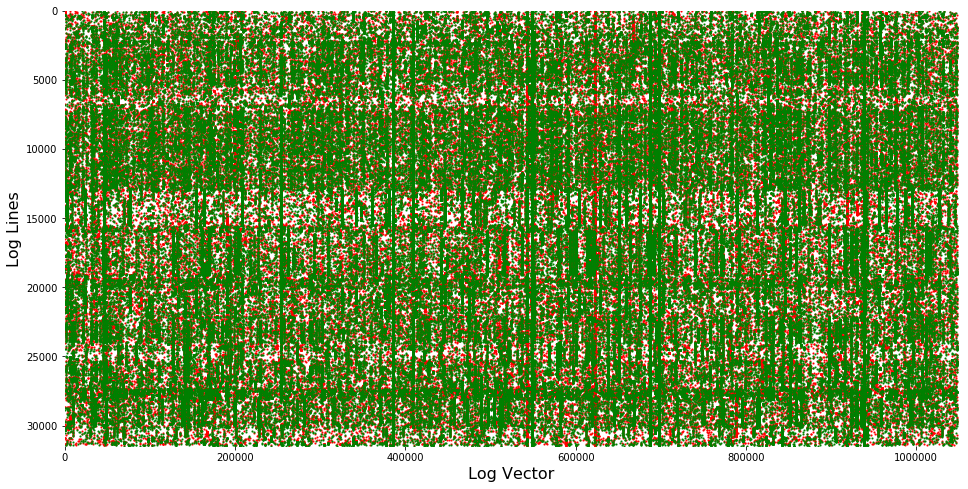

In [11]:
plot_features_vectors(V_success, V_failure, figsize=(16, 8))

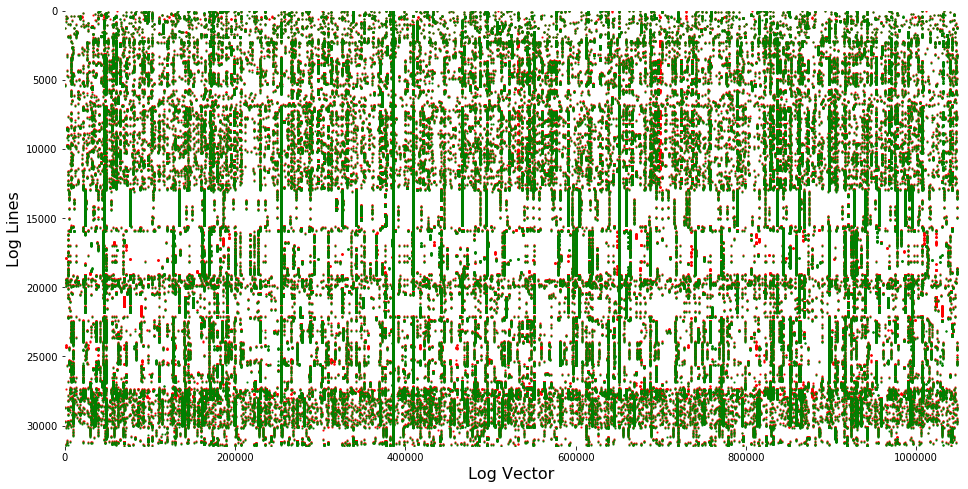

In [12]:
# Remove all numbers before vectorization
vectorizer = HashingVectorizer()
T_success = list(map(lambda x: re.subn(r'[0-9]', '', x)[0], X_success))
T_failure = list(map(lambda x: re.subn(r'[0-9]', '', x)[0], X_failure))
V_success = vectorizer.transform(T_success)
V_failure = vectorizer.transform(T_failure)
plot_features_vectors(V_success, V_failure, figsize=(16, 8))

In [13]:
# Train the model using the cleaned vector
nn = NearestNeighbors()
nn.fit(V_success)
# Compute the distance
distances = nn.kneighbors(V_failure)[0]

In [14]:
min_distance = 0.3
for idx in range(len(X_failure)):
    if distances[idx][0] >= min_distance:
        min_distance = distances[idx][0]
        print("%.2f | %s" % (distances[idx][0], X_failure[idx][:-1]))

0.52 | 2018-02-22 00:15:11.356972 | controller -> localhost | Your identification has been saved in /var/lib/zuul/builds/e527168cb947472aaabadca9c360a8d4/work/e527168cb947472aaabadca9c360a8d4_id_rsa.
0.80 | 2018-02-22 00:15:11.357335 | controller -> localhost | SHA256:j8R7j6w+IZ0V6XEw761Uo+G7f+ss9V8zmnq8mZjNBAU zuul@ze08
1.00 | 2018-02-22 00:16:31.654778 | controller -> localhost |  * [new tag]         12.0.0.0rc2 -> 12.0.0.0rc2
1.00 | 2018-02-22 00:17:23.138733 | controller |   "key": "149.202.172.24 ssh-rsa AAAAB3NzaC1yc2EAAAADAQABAAABAQCnu5VGRUCsYRfhiMnwJWIDzUP77swRD5X/ENcQX8L9JE9vpjlex5ABAacflupBMMeWvC3C0JZDmdK941bgvw9JtAxlc4goP+hELUAaawXLAKMuV0g3jNC5Zoj6pP+vI8ie48i7zCCh8a/gWYOQDuME2AMQ1DpG6VLm2vVSsgkVnybtHfatOvAvyu62WZlCWJTR1Dilfk/mlFpPvRd0uFLsOE26A3xIkOpAluuHfsPFMAVvTzwbYBj/eyIDtPn2hESUyF4UNjxsu+/Y2OC+w0zS0w/ypqZvfu6qU1Bod8pc4R42wPzgZ2pt+9HfrxLiiAovSEddjGO4ybMFHZnpTV+B",
1.00 | 2018-02-22 00:17:24.742290 | controller |   "key": "2001:41d0:302:1000::10:307c ssh-rsa AAAAB3NzaC1yc2E